In [1]:
# --------------------------------- Libaries --------------------------------- #
import logging
import os
import re
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from transformers import AutoModel, AutoTokenizer
from transformers import BertTokenizer
from transformers import BertModel

import torch
import torch.nn as nn


In [2]:
raw_text = pd.read_csv('./data/_PHEME_text.csv')
y = pd.read_csv('./data/_PHEME_target.csv')
data = pd.concat([raw_text.text, y], axis=1).reset_index(drop=True)
val = pd.read_csv('data/_PHEMEext_text.csv')

X_train = data.text.values
y_train = data.target.values

X_val = val.drop(['Event'],axis=1).text.values
y_val = val.target.values

rhi_data = pd.read_csv('data/_RHI_text.csv')
rhi_y = pd.read_csv('data/_RHI_text.csv')
raw_text = pd.read_csv('./data/_PHEME_text.csv')

urls = pd.read_csv('./data/urls_sum.csv')
data = pd.read_csv('./data/data_notembeded.csv')


FileNotFoundError: [Errno 2] No such file or directory: './data/urls_sum.csv'

# URLS

## Process

In [296]:
y.shape

(5802, 1)

In [262]:
durl = data[['hasURL','urls','urls_expanded','hasUserURL','user_url','isRumor']]
durl

,hasURL,urls,urls_expanded,hasUserURL,user_url,isRumor
0,1,['http://t.co/PBs3sMwhLt'],['http://htz.li/1lI'],1,http://www.haaretz.com,1
1,0,[],[],1,http://www.agnespoirier.org,1
2,0,[],[],1,http://t.co/EWb7m4orG8,1
3,1,"['http://t.co/3tGXEIX4F2', 'https://t.co/aBSez...","['http://cnn.it/1xYDHvp', 'https://amp.twimg.c...",1,http://www.cnn.com,1
4,1,['http://t.co/3Jsosc7yl3'],['http://on.rt.com/k5ivya'],1,http://t.co/bDDyvy9DmR,1
...,...,...,...,...,...,...
5797,1,['http://t.co/llZnuCAzg5'],['http://bbc.in/1DArzWS'],1,http://bbc.com/trending,0
5798,0,[],[],1,http://t.co/L2SH1QDkAY,0
5799,1,['https://t.co/sZdyhISoVh'],['https://www.youtube.com/watch?v=d8c38_46W5c'],1,http://t.co/uTUmOx49Zj,0
5800,1,['http://t.co/6Lrl9DEMXA'],['http://bbc.in/1znVJHB'],1,http://www.bbc.co.uk/news,0


In [263]:
durl.urls_expanded.value_counts()


[]                                                                                                           3447
['http://www.telegraph.co.uk/news/worldnews/europe/france/11329976/Paris-Charlie-Hebdo-attack-live.html']      16
['http://f24.my/YTliveEN']                                                                                     15
['http://bbc.in/1vPDuWA']                                                                                      13
['http://cnn.it/1Ds26xN']                                                                                      13
                                                                                                             ... 
['https://vine.co/v/OpKlP5Fzgv7']                                                                               1
['http://bit.ly/1uPl76o']                                                                                       1
['http://bbc.in/1BDCU5w']                                                               

In [297]:
import os

pattern = r'[(http://)|\w]*?[\w]*\.[-/\w]*\.\w*[(/{1})]?[#-\./\w]*[(/{1,})]?'
urlslist=[]

for i, l in enumerate(durl.urls_expanded):
    l = re.sub(r'\'',"",l)
    res = re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', l)
    urlslist.append(res)

link=pd.concat([pd.DataFrame(urlslist),y],axis=1)
link[0] = link[0].str.replace('https://(www.)|https://|http://|www://', '', case=False)
link[1] = link[1].str.replace('https://(www.)|https://|http://|www://', '', case=False)


<ipython-input-297-65cb89235ccc>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  link[0] = link[0].str.replace('https://(www.)|https://|http://|www://', '', case=False)
<ipython-input-297-65cb89235ccc>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  link[1] = link[1].str.replace('https://(www.)|https://|http://|www://', '', case=False)


In [298]:
link.sample(4)

,0,1,target
1648,None,None,0
33,ind.pn,None,1
4398,None,None,0
3978,None,None,1


In [304]:
link[0].value_counts()

bit.ly                          174
bbc.in                          151
cnn.it                          137
on.rt.com                        86
ind.pn                           72
                               ... 
www.JusticeForMikeBrown.org       1
www.newstatesman.com              1
www.services3.rcmp-grc.gc.ca      1
homemigraineremedies.com          1
abc.net.au                        1
Name: 0, Length: 357, dtype: int64

In [293]:
link[0].loc[link[0].values != None].value_counts()

bit.ly                       174
bbc.in                       151
cnn.it                       137
on.rt.com                     86
ind.pn                        72
                            ... 
uk.businessinsider.com         1
www.ksdk.com                   1
blog.peta.org.uk               1
theverge.com                   1
www.indexoncensorship.org      1
Name: 0, Length: 357, dtype: int64

<AxesSubplot:ylabel='0'>

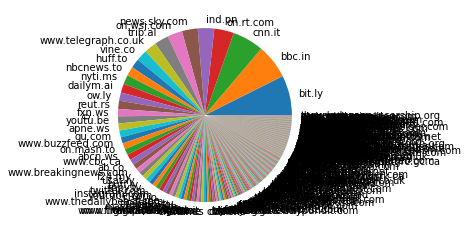

In [292]:
# data.urls.value_counts().plot(kind="bar")
# link[0].loc[link[0].values != None].value_counts().plot(kind="hist")
link[0].loc[link[0].values != None].value_counts().plot(kind="pie")
# data.urls.value_counts().plot(kind="density")
# data.urls.value_counts().plot(kind="area")
# link[0].value_counts().plot(kind="pie")
# data.urls.value_counts().plot(kind="hexbin")

In [ ]:
data.urls.value_counts()

In [ ]:
data.urls.value_counts()

## CODE

In [442]:
import seaborn as sns
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 400)

In [110]:
import os
# Warning('ignore')
data = pd.read_csv('./data/data_notembeded.csv')

durl = data[['hasURL','urls','urls_expanded','hasUserURL','user_url','isRumor']]

pattern = r'[(http://)|\w]*?[\w]*\.[-/\w]*\.\w*[(/{1})]?[#-\./\w]*[(/{1,})]?'
urlslist=[]

for i, l in enumerate(durl.urls_expanded):
    l = re.sub(r'\'',"",l)
    res = re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', l)
    urlslist.append(res)

link=pd.concat([pd.DataFrame(urlslist),data.isRumor],axis=1)
link[0] = link[0].str.replace('https://(www.)|https://|http://|www.', '', case=False)
link[1] = link[1].str.replace('https://(www.)|https://|http://|www://|www.', '', case=False)
link.columns = ['link1', 'link2', 'target']

<ipython-input-110-f17fb75292be>:16: FutureWarning: The default value of regex will change from True to False in a future version.
  link[0] = link[0].str.replace('https://(www.)|https://|http://|www.', '', case=False)
<ipython-input-110-f17fb75292be>:17: FutureWarning: The default value of regex will change from True to False in a future version.
  link[1] = link[1].str.replace('https://(www.)|https://|http://|www://|www.', '', case=False)


KeyError: 0

In [468]:
# link.link1.value_counts().unique()
# sns.barplot(x='link1',y='target',data=link)
# pd.DataFrame(link[['link1', 'target']].dropna().value_counts())
# loc['youtube' in link['link1']]
# pd.DataFrame(link[['link1', 'target']].value_counts()).loc[link['link1'].count() > 5]
link['link1'].count()


2355

In [507]:
good.loc[good['sum']>8]

,0,1,count,sum
link1,,,,
ab.co,52.000000,48.000000,25,12
abcn.ws,38.461538,61.538462,26,16
apne.ws,38.709677,61.290323,31,19
bbc.in,50.331126,49.668874,151,75
bit.ly,55.172414,44.827586,174,78
breakingnews.com,28.000000,72.000000,25,18
buzzfeed.com,55.555556,44.444444,27,12
cbc.ca,25.806452,74.193548,31,23
cnn.it,57.664234,42.335766,137,58


In [505]:
good = pd.concat([pd.crosstab(link['link1'], link['target'], normalize='index').mul(100), link.groupby('link1').agg(['count', 'sum'])], axis=1)
good.columns=['0','1','count','sum']
good

,0,1,count,sum
link1,,,,
20minutes.fr,0.000000,100.000000,2,2
500views.com,0.000000,100.000000,1,1
9news.com.au,0.000000,100.000000,3,3
ABCNews.com,50.000000,50.000000,6,3
CNN.it,50.000000,50.000000,2,1
DashCamDiaries.com,0.000000,100.000000,1,1
JusticeForMikeBrown.org,100.000000,0.000000,1,0
NBA.com,100.000000,0.000000,1,0
OpFerguson.com,100.000000,0.000000,1,0


In [356]:
print(len(link.link1.unique()))
unique = link.link1.unique()


350


In [453]:
for i, d in enumerate(link.link1):
    if (d != None):
        if (re.findall('facebook|fb.me', d)): link.link1[i] = 'facebook'
        elif (re.findall('^google|goo.gl', d)): link.link1[i] = 'google'
        elif (re.findall('instagram', d)): link.link1[i] = 'instagram'
        elif (re.findall('huff', d)): link.link1[i] = 'huffingtonpost'
        elif (re.findall('youtu', d)): link.link1[i] = 'youtube'
        elif (re.findall('yahoo', d)): link.link1[i] = 'yahoo'

for i, d in enumerate(link.link2):
    if (d != None):
        if (re.findall('facebook|fb.me', d)): link.link2[i] = 'facebook'
        elif (re.findall('^google|goo.gl', d)): link.link2[i] = 'google'
        elif (re.findall('instagram', d)): link.link2[i] = 'instagram'
        elif (re.findall('huff', d)): link.link2[i] = 'huffingtonpost'
        elif (re.findall('youtu', d)): link.link2[i] = 'youtube'
        elif (re.findall('yahoo', d)): link.link2[i] = 'yahoo'


<ipython-input-453-6dcb1aceacdd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elif (re.findall('instagram', d)): link.link1[i] = 'instagram'
<ipython-input-453-6dcb1aceacdd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elif (re.findall('youtu', d)): link.link1[i] = 'youtube'
<ipython-input-453-6dcb1aceacdd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elif (re.findall('huff', d)): link.link1[i] = 'huffingtonpost'
<ipython-i

In [457]:
# for i, d in enumerate(link.link1):
#     if (d != None):
#         if (re.findall('facebook|fb.me', d)): print(d)
#         # if (re.findall('^google|goo.gl', d)): print(d)
#         # elif (re.findall('instagram', d)): print(d)
#         # elif (re.findall('huff', d)): print(d)
#         # elif (re.findall('youtu', d)): print(d)
#         elif (re.findall('yahoo', d)): print(d)



# CV

# PHEME-ALL


In [3]:
import pandas as pd
import numpy as np

from glob2 import glob
import json

pd.options.display.float_format = '{:.0f}'.format
def capitalratio(tweet_text):
    uppers = [l for l in tweet_text if l.isupper()]
    capitalratio = len(uppers) / len(tweet_text)
    return capitalratio 


def fetchRawText(path, events, tweetType):
    jsons = []
    for i, event in enumerate(events):
        jsons.append(glob('%s/%s/**/%s/[0-9]*.json' % (path, event, tweetType)))
    for i,d in enumerate(jsons): print("%s's length is %d" %(events[i], len(d)))
    

    targets = []
    features = []
    isSrcTweet = []
    for index, dataset in enumerate(jsons):
        targetEvent = []
        dataEvent = []
        count = 0  # help var
        for jsonFile in dataset:
            count += 1
            if jsonFile.find("non-rumours") == -1:
                targetEvent.append(1)
            else:
                targetEvent.append(0)
            if jsonFile.find("source-tweet") == -1:
                isSrcTweet.append(0)
            else: #if jsonFile.find("reactions") == 1:
                isSrcTweet.append(1)
                

            with open(jsonFile, 'r') as f:
                for l in f.readlines():
                    if not l.strip():  # skip empty lines
                        continue
                    json_data = json.loads(l)
                    # try:
                    # except:
                    #     print(jsonFile)
                    #     continue
                    # print (json_data,"\n\n")
                    dataEvent.append(json_data)
        # print(index, events[index], len(targetEvent), len(dataEvent))
        targets.append(targetEvent)
        features.append(dataEvent)
        # isSrcTweet.append(isSrcTweet)

    # print("\nNumber of Events:", len(targets))
    # print("Number of tweets in the first event:", len(targets[0]))

    # targets은 targetEvent들을 리스트에 담은 것
    target_list = []
    for event in targets:
        for elem in event:
            target_list.append(elem)
    target = pd.DataFrame(target_list, columns=["target"])
    isSrcTweet = pd.DataFrame(isSrcTweet, columns=["isSrcTweet"])

    extracted_features = []

    extracted = []

    # features[0][50]
    # print(len(features))
    for obj_list in features:
        # print(len(obj_list))
        extracted_event = []
        for obj in obj_list:
            # print(obj)
            output_f = dict()
            if ('text' in obj):
                output_f['text'] = obj['text']
            else:
                output_f['text'] = None
            if ('id' in obj):
                output_f['id'] = obj['id']
            else:
                output_f['id'] = None
            if ('in_reply_to_status_id' in obj):
                output_f['PID'] = obj['in_reply_to_status_id']
            else:
                output_f['PID'] = None

            output_f['char_count'] = len(output_f['text'])
            output_f['word_count'] = len(output_f['text'].split())

            output_f['has_question'] = "?" in output_f["text"]
            output_f['has_exclaim'] = "!" in output_f["text"]
            output_f['has_period'] = "." in output_f["text"]

            output_f['capital_ratio']=(capitalratio(obj['text']))
            output_f['tweet_count'] = np.log10(obj['user']['statuses_count'])
            output_f['listed_count'] = obj['user']['listed_count']
            output_f['friends_count'] = obj['user']['friends_count']
            output_f['follow_ratio'] = np.log10(obj['user']['followers_count'])
            extracted_event.append(output_f)
        extracted_features.append(extracted_event)

    extracted_df = []
    # print(events)
    # print(len(extracted_features))
    for i, data in enumerate(extracted_features):
        # print(i)
        temp = pd.DataFrame(data)
        temp["Event"] = events[i]
        extracted_df.append(pd.DataFrame(temp))

    final = pd.concat(extracted_df, ignore_index=True)
    final = pd.concat([final, isSrcTweet ,target], axis=1)
    return final

## PHEME

In [4]:
path = "../pheme-rnr-dataset"
events = ['charliehebdo', 'ferguson',
          'germanwings-crash', 'ottawashooting', 'sydneysiege']
# events = ['ottawashooting']
tweetType = '*'
final = fetchRawText(path, events, tweetType)

KeyboardInterrupt: 

In [173]:
print(final.shape)
final.head()

(103211, 5)


,text,id,Event,isSrcTweet,target
0,BREAKING: Armed man takes hostage in kosher gr...,553529101659566080,charliehebdo,1,1
1,“@haaretzcom: BREAKING: Armed man takes hostag...,553530890908098561,charliehebdo,0,1
2,@haaretzcom @AhmetHez to kill is right? How da...,553547184000339968,charliehebdo,0,1
3,@haaretzcom @AhmetHez play back infront of ur ...,553546643941761024,charliehebdo,0,1
4,@ohohyesyesnono @haaretzcom Bots will conquest...,553530583583047680,charliehebdo,0,1


In [176]:
# final.to_csv('./data/all/_PHEMEall_text.csv', index = False)

## PHEMEext

In [17]:
def getThreadData(events):
    import re

    sources = []
    for i, event in enumerate(events):
        sources.append(glob('%s/%s/*/*' % (path, event)))
    for i, d in enumerate(sources):
        print("%s's length is %d" % (events[i], len(d)))

    roots = []
    children = []
    features = []
    isSrcTweet = []
    for num, event in enumerate(sources):
        for index, dataset in enumerate(event):
            # print(dataset)
            # children.append(glob('%s/reactions/*/*' % (dataset)))
            childs = [os.path.basename(x) for x in glob('%s/reactions/*.json' % (dataset))]
            reext = re.compile(r'(.*?)\.json')
            childs = (reext.match(child) for child in childs)
            children.append([match.group(1) for match in childs if match])
            # print(dataset)
            roots.append(os.path.basename(dataset))

    df = pd.DataFrame(roots, columns=['Root'])
    df = pd.concat([df,pd.DataFrame(children)],axis=1)
    return df

In [18]:
getThreadData(['ebola-essien'])

ebola-essien's length is 14


,Root,0,1,2,3,4,5,6,7,8,...,16,17,18,19,20,21,22,23,24,25
0,521369179392581632,521410632953131008,521373142347153409,521369380249432064,521370496928337920,521370224256614400,521370771793670144,521378607231279104,521370530134626307,521373433654157312,...,None,None,None,None,None,None,None,None,None,None
1,521367917322338304,521368486053150721,521368752135610368,521368241944662017,521368597734912000,521792966776877056,521368183358648321,521368281526321152,521368265768321024,521368316976582657,...,521368587894661121,521368140337672192,None,None,None,None,None,None,None,None
2,522286703848218624,522288012705935360,522288706422448128,522295631801753600,522296320867196929,522291744176898048,522297427492339712,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,521375609206083584,521399340095791104,521448397543600128,521375890908143616,521428664567988224,521465534517608448,521419413573353472,521419674089959424,521446676100550656,521375739489579008,...,None,None,None,None,None,None,None,None,None,None
4,521358118597689344,521361636658278400,521381205464584192,521359905614090240,521359510473277440,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
5,521381662551474176,521425207039623168,521410492037091329,521409574658928643,521383201198309376,521382867973464064,521381891967295488,521397253970612224,521382004433371137,521393860942254081,...,521509907766718464,521404199058567169,521660531468689408,None,None,None,None,None,None,None
6,521346721226711040,521371742942797825,521367905062379521,521356252740608001,521355922724388865,521352186949672960,521353020484096001,521353434881327104,521366172529201153,521351752734769152,...,521368022880378882,521366121484918785,521367512551002112,521350466647891968,521349434719076352,521351041154289665,521367394108071936,521352738891132929,521352500604309506,521371539082858496
7,521360486387175424,521468392620834817,521378427681898498,521371350934761472,521360786409943041,521376439099465728,521373767130710016,521468848466591744,521368262010224640,None,...,None,None,None,None,None,None,None,None,None,None
8,521359863884967936,521360035872800768,521361503799103489,521363927671013376,521360522579836928,521363843650691073,521361442050551808,521360483551825920,521361609688903680,521364073917976576,...,None,None,None,None,None,None,None,None,None,None
9,521595221155774464,521597271709077505,521596335573962752,521605410084888577,521595606889144320,521595784983511040,521603828417044480,521615893517070336,521597399295619072,521596530974019584,...,None,None,None,None,None,None,None,None,None,None


In [6]:
path = "../PHEME/all-rnr-annotated-threads"
events = ['ebola-essien', 'prince-toronto', 'putinmissing']
tweetType = '*'
finalext = fetchRawText(path,events,tweetType)
print(finalext.shape)
finalext.head()

ebola-essien's length is 226
prince-toronto's length is 902
putinmissing's length is 835
(1963, 16)


,text,id,PID,char_count,word_count,has_question,has_exclaim,has_period,capital_ratio,tweet_count,listed_count,friends_count,follow_ratio,Event,isSrcTweet,target
0,@Mourinholic 😕😕 http://t.co/sFoV1v8uDo,521410632953131008,521369179392581632,38,3,False,False,True,0,5,16,1374,4,ebola-essien,0,1
1,“@Mourinholic: Micheal Essien denying the Ebol...,521373142347153409,521369179392581632,85,9,False,False,True,0,4,8,1261,3,ebola-essien,0,1
2,@Mourinholic Hmmm.,521369380249432064,521369179392581632,18,2,False,False,True,0,5,15,78,3,ebola-essien,0,1
3,"@Mourinholic Even though it was against us, it...",521370496928337920,521369179392581632,73,13,False,False,True,0,3,0,224,2,ebola-essien,0,1
4,@CdtChoco1er thanks bro.,521370224256614400,521370061550809088,24,3,False,False,True,0,5,159,670,4,ebola-essien,0,1


In [7]:
root = finalext.loc[finalext.PID.isna() == True]
print('The # of Root|Reaction tweets: %d|%d from %s'%(root.shape[0],finalext.shape[0]-root.shape[0], finalext.shape[0]))

The # of Root|Reaction tweets: 485|1478 from 1963


In [10]:
root

,text,id,PID,char_count,word_count,has_question,has_exclaim,has_period,capital_ratio,tweet_count,listed_count,friends_count,follow_ratio,Event,isSrcTweet,target
14,Micheal Essien denying the Ebola rumours like ...,521369179392581632,NaN,69,8,False,False,True,0,5,148,652,4,ebola-essien,1,1
33,No truth in internet rumours that I have contr...,521367917322338304,NaN,148,25,False,False,True,0,3,1623,176,6,ebola-essien,1,1
40,Essien and his lawyers are considering to file...,522286703848218624,NaN,119,20,False,False,True,0,5,2165,144,5,ebola-essien,1,1
53,Good news: The rumours that Michael Essien has...,521375609206083584,NaN,130,16,False,False,True,0,4,608,716,5,ebola-essien,1,1
58,Milan have stated that the reports about Essie...,521358118597689344,NaN,120,15,False,False,True,0,5,2165,144,5,ebola-essien,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1954,Ex-KGB Yuri Shvets at #Litvinenko inquiry-#Put...,576509905596727296,NaN,138,15,False,False,True,0,4,118,2680,4,putinmissing,1,0
1955,"Death came for Pratchett, picked up Putin for ...",576464933648371712,NaN,64,10,False,False,False,0,3,4,276,2,putinmissing,1,0
1957,the plot thickens - #putindead http://t.co/Vie...,576387464924819456,NaN,53,6,False,False,True,0,5,38,494,3,putinmissing,1,0
1961,Putin juggling enough instability. He would ma...,576443643680178176,NaN,103,16,False,False,True,0,4,146,878,4,putinmissing,1,0


In [11]:
import math

print(root.loc[0:100].PID.values)
print(root.PID.iloc[14]) #40
print(math.isnan(root.iloc[14].PID))
print(type(root.PID.iloc[14]))

[nan nan nan nan nan nan]
nan
True
<class 'numpy.float64'>


In [175]:
# finalext.to_csv('./data/all/_PHEMEextall_text.csv', index = False)

# 모델 체크포인트

In [ ]:
early_stopping =EarlyStopping(monitor='val_loss', patience=3)

bst_model_path = STAMP + '.h5'

model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)
